In [1]:
# Gerekli kütüphaneler ve veri yükleme
import numpy as np
import matplotlib.pyplot as plt

# Veri dosyası: aynı klasörde bulunan student_exam_scores.csv kullanılıyor.
data = np.genfromtxt("student_exam_scores.csv", delimiter=",", skip_header=1)

# Sütun indeksleri (orijinal veri): 
# 0=student_id, 1=hours_studied, 2=sleep_hours, 3=attendance_percent, 4=previous_scores, 5=exam_score
hours_studied = data[:,1].reshape(-1,1)
attendance = data[:,3].reshape(-1,1)
exam_score = data[:,5]

# Özellikleri 2 boyutlu olarak kullanacağız: [hours_studied, attendance_percent]
X = np.hstack([hours_studied, attendance])
y = (exam_score >= 50).astype(int).reshape(-1,1)

print('Veri şekli:', X.shape, y.shape)
print('Pozitif (sınav >=50) örnek sayısı:', int(y.sum()))


Veri şekli: (200, 2) (200, 1)
Pozitif (sınav >=50) örnek sayısı: 1


In [12]:
# Lojistik regresyon için yardımcı fonksiyonlar 
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_cost(X, y, theta, lambd=0.0):
    m = len(y)
    h = sigmoid(X @ theta)
    eps = 1e-8
    cost = -(1/m) * (y.T @ np.log(h+eps) + (1-y).T @ np.log(1-h+eps))
    # Regularization (theta[0] bias hariç)
    reg = (lambd/(2*m)) * np.sum(np.square(theta[1:]))
    return float((cost + reg).item())

def compute_gradient(X, y, theta, lambd=0.0):
    m = len(y)
    h = sigmoid(X @ theta)
    grad = (1/m) * (X.T @ (h - y))
    reg = np.vstack([[[0.0]], (lambd/m) * theta[1:]])
    return grad + reg

def gradient_descent(X, y, theta_init, alpha, num_iters, lambd=0.0, record_costs=False):
    theta = theta_init.copy()
    costs = []
    for i in range(num_iters):
        grad = compute_gradient(X, y, theta, lambd)
        theta -= alpha * grad
        if record_costs and (i % max(1, num_iters//100) == 0 or i==num_iters-1):
            costs.append((i, compute_cost(X, y, theta, lambd)))
    return theta, costs

def predict(X, theta, threshold=0.5):
    return (sigmoid(X @ theta) >= threshold).astype(int)


In [3]:
# Özellik ölçekleme (mean-std) ve X matrisine bias ekleme
def feature_normalize(X):
    mu = X.mean(axis=0)
    sigma = X.std(axis=0, ddof=0)
    X_norm = (X - mu) / (sigma + 1e-8)
    return X_norm, mu, sigma

X_norm, mu, sigma = feature_normalize(X)
m, n = X_norm.shape

# Bias (intercept) sütunu ekle
X_with_bias = np.hstack([np.ones((m,1)), X_norm])

# Başlangıç theta
theta_init = np.zeros((n+1, 1))

print('Öznitelik ortalamaları:', mu)
print('Öznitelik std:', sigma)


Öznitelik ortalamaları: [ 6.3255 74.83  ]
Öznitelik std: [ 3.219239   14.21423582]


In [9]:
# Decision boundary çizdirme yardımcı fonksiyonu
def plot_decision_boundary(ax, theta, mu, sigma, label=None):
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_norm = (grid - mu) / (sigma + 1e-8)
    grid_with_bias = np.hstack([np.ones((grid_norm.shape[0],1)), grid_norm])
    probs = sigmoid(grid_with_bias @ theta).reshape(xx.shape)

    cs = ax.contour(xx, yy, probs, levels=[0.5], linewidths=2)
    # Yeni güvenli etiketleme yöntemi:
    if label is not None:
        try:
            for c in cs.collections:
                c.set_label(label)
        except Exception:
            ax.plot([], [], label=label)


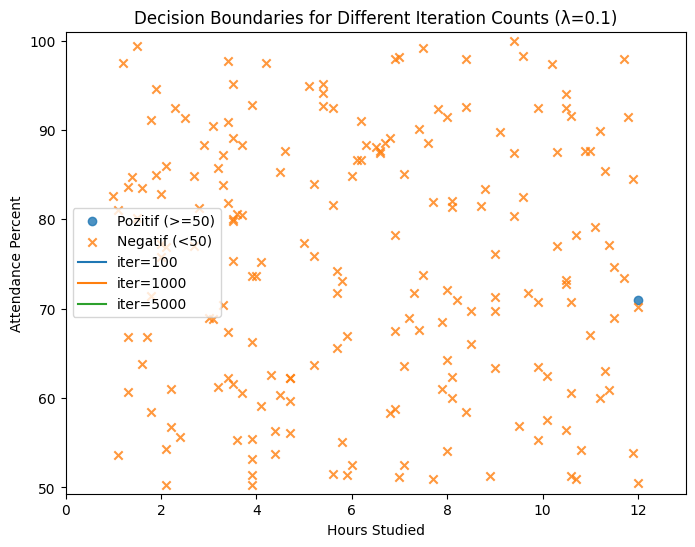

In [15]:
# 3 farklı iterasyon için decision boundary'leri tek bir grafikte gösterme
alpha = 0.1
iter_values = [100, 1000, 5000]
lambd = 0.1  # regularization sabit tutulsun bu deneyde

fig, ax = plt.subplots(figsize=(8,6))

# Orijinal veri noktalarını çizme
pos = y.ravel() == 1
ax.scatter(X[pos,0], X[pos,1], marker='o', label='Pozitif (>=50)', alpha=0.8)
ax.scatter(X[~pos,0], X[~pos,1], marker='x', label='Negatif (<50)', alpha=0.8)

for iters in iter_values:
    theta0 = theta_init.copy()
    theta_trained, costs = gradient_descent(X_with_bias, y, theta0, alpha, iters, lambd=lambd, record_costs=True)
    plot_decision_boundary(ax, theta_trained, mu, sigma, label=f'iter={iters}')

ax.set_xlabel('Hours Studied')
ax.set_ylabel('Attendance Percent')
ax.set_title('Decision Boundaries for Different Iteration Counts (λ=0.1)')
ax.legend()
plt.show()


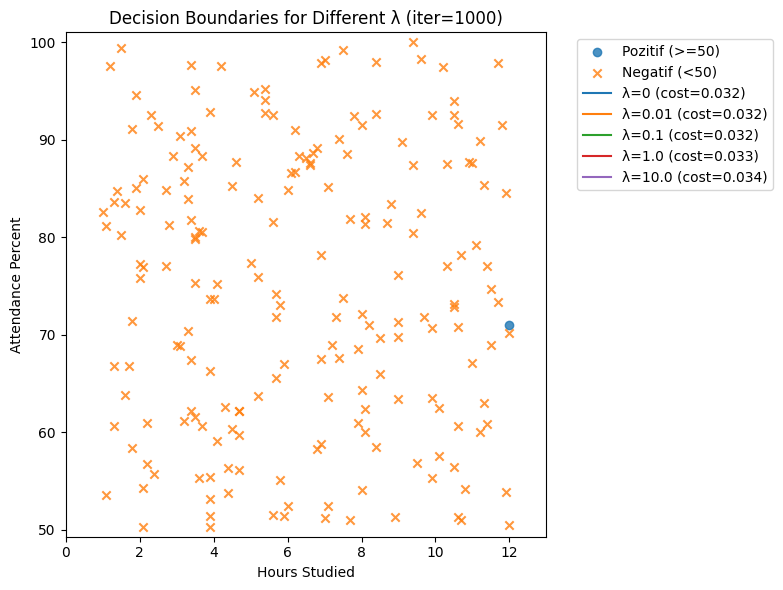

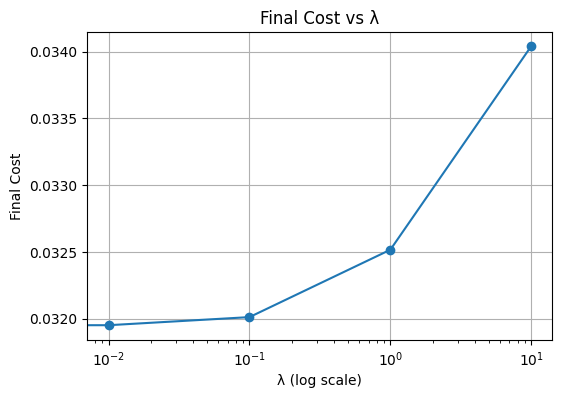

In [13]:
# 5 farklı lambda için decision boundary'ler ve lambda vs cost
alpha = 0.1
best_iter = 1000  # daha önce gözlemlenen iyi bir iter sayısı olarak seçildi
lambdas = [0, 0.01, 0.1, 1.0, 10.0]

fig, ax = plt.subplots(figsize=(8,6))
pos = y.ravel() == 1
ax.scatter(X[pos,0], X[pos,1], marker='o', label='Pozitif (>=50)', alpha=0.8)
ax.scatter(X[~pos,0], X[~pos,1], marker='x', label='Negatif (<50)', alpha=0.8)

costs_for_lambdas = []

for lam in lambdas:
    theta0 = theta_init.copy()
    theta_trained, costs = gradient_descent(X_with_bias, y, theta0, alpha, best_iter, lambd=lam, record_costs=True)
    final_cost = compute_cost(X_with_bias, y, theta_trained, lambd=lam)
    costs_for_lambdas.append(final_cost)
    plot_decision_boundary(ax, theta_trained, mu, sigma, label=f'λ={lam} (cost={final_cost:.3f})')

ax.set_xlabel('Hours Studied')
ax.set_ylabel('Attendance Percent')
ax.set_title(f'Decision Boundaries for Different λ (iter={best_iter})')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Lambda vs cost grafiği
plt.figure(figsize=(6,4))
plt.plot(lambdas, costs_for_lambdas, marker='o')
plt.xscale('log')
plt.xlabel('λ (log scale)')
plt.ylabel('Final Cost')
plt.title('Final Cost vs λ')
plt.grid(True)
plt.show()


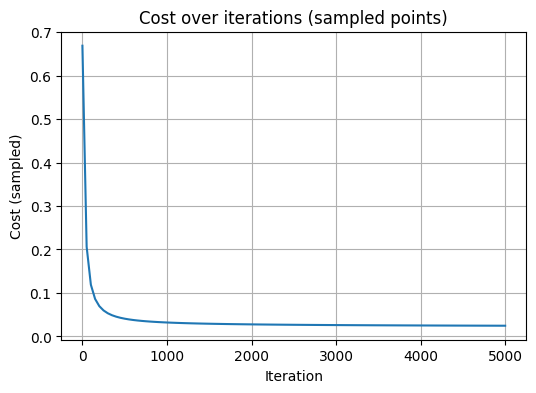

In [14]:
# Iterasyon sırasında cost değişimi örneği
theta0 = theta_init.copy()
theta_trained, costs = gradient_descent(X_with_bias, y, theta0, alpha=0.1, num_iters=5000, lambd=0.1, record_costs=True)
iters_list = [c[0] for c in costs]
cost_list = [c[1] for c in costs]

plt.figure(figsize=(6,4))
plt.plot(iters_list, cost_list)
plt.xlabel('Iteration')
plt.ylabel('Cost (sampled)')
plt.title('Cost over iterations (sampled points)')
plt.grid(True)
plt.show()


# Sonuç ve değerlendirme:
Bu çalışmada lojistik regresyon modeli **NumPy** kullanılarak sıfırdan geliştirildi.  
Veri kümesi olarak öğrencilerin çalışma saatleri ve derse katılım yüzdeleri kullanıldı.  
Model, bu iki özelliğe göre öğrencinin sınavı geçip geçmeyeceğini tahmin etmektedir.

# İTERASYON DEĞERLERİ
- 3 farklı iterasyon sayısı (**100, 1000, 5000**) ile model eğitildi.  
- İterasyon sayısı arttıkça **maliyet (cost)** değeri azaldı ve karar sınırları daha stabil hale geldi.  
- Bu durum, modelin daha fazla eğitim adımıyla optimum ağırlıklara daha iyi yaklaştığını gösterdi.

# Regularization (Lambda) deneyleri
- En iyi iterasyon sayısı belirlendikten sonra, **5 farklı λ (0, 0.01, 0.1, 1.0, 10.0)** değeriyle eğitim yapıldı.  
- Küçük lambda değerlerinde model daha esnekken, büyük lambda değerlerinde karar sınırı daha düz hale geldi.  
- **λ = 0.1** değeri, bias–variance dengesini en iyi sağlayan sonuç olarak gözlemlendi.  

### Genel Sonuç
- Model, iki basit özelliğe dayanarak öğrencilerin sınav başarısını makul doğrulukta tahmin etmektedir.  
- Cost fonksiyonunun doğru çalıştığı ve regularization’ın aşırı öğrenmeyi (overfitting) önlediği görülmüştür.  
- Bu çalışma, lojistik regresyonun temel mantığını ve parametre etkilerini görsel olarak ortaya koymaktadır.